# Brain Tumor Classification using Deep Learning

The following notebook will perform brain tumor classification using Deep Learning. Our objective is to use a [Kaggle](https://www.kaggle.com/masoudnickparvar/brain-tumor-mri-dataset) dataset consisting of 7022 brain scans of which includes brains with giloma tumor, meningioma tumor, pituitary tumor and healthy brains. 

<img src="https://www.stlukeshealth.org/content/dam/stlukeshealth/images/brain-cancer-banner.png" align="left" />

In [1]:
import torch
import torch.nn as nn
import numpy as np
import cv2, os, glob, random
import matplotlib.pyplot as plt
import elasticdeform

from sklearn.model_selection import train_test_split, StratifiedKFold

## Data exploration

Before jumping into writing models or makingg any statistical assesment, it is important that we study and understand the data we have. Let's plot some graphs and explore some numbers.

#### Place file paths in dictionary

In [2]:
training_images_paths = {}
testing_images_paths = {}

def add_img(d, imgType, imgPath):
    if imgType not in d:
        d[imgType] = [imgPath]
    else:
        d[imgType].append(imgPath)

for trainingImgPath in glob.glob("data/Training/*"):
    imgType = trainingImgPath.split("/")[-1]
    for img in glob.glob(f"data/Training/{imgType}/*"):
        add_img(training_images_paths, imgType, img)
        
for testingImgPath in glob.glob("data/Testing/*"):
    imgType = testingImgPath.split("/")[-1]
    for img in glob.glob(f"data/Testing/{imgType}/*"):
        add_img(testing_images_paths, imgType, img)

#### Plot training and test images quantity vs tumor type

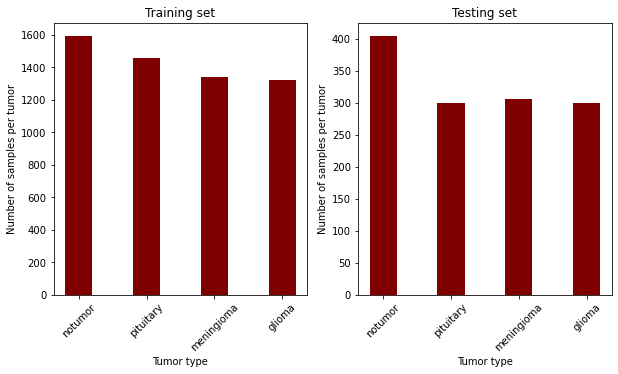

In [3]:
tumors = list(training_images_paths.keys())
tumorTrainingLength =  []
tumorTestingLength =  []

for tumorType in tumors:
    tumorTrainingLength.append(len(training_images_paths[tumorType]))
    tumorTestingLength.append(len(testing_images_paths[tumorType]))

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.subplot(1,2,1)
plt.bar(tumors, tumorTrainingLength, color ='maroon',
        width = 0.4)
 
plt.xlabel("Tumor type")
plt.ylabel("Number of samples per tumor")
plt.title("Training set")
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.bar(tumors, tumorTestingLength, color ='maroon',
        width = 0.4)
 
plt.xlabel("Tumor type")
plt.ylabel("Number of samples per tumor")
plt.title("Testing set")
plt.xticks(rotation=45)

plt.show()

The dataset are well balanced in both training and testing sets.

#### Data observation
Let's observe some brain scans of different types of brain tumors.

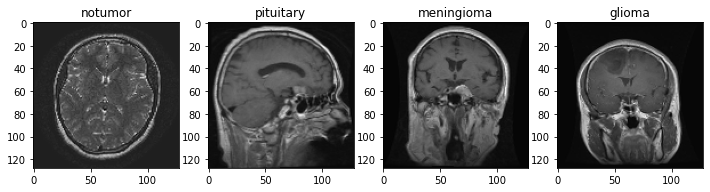

In [113]:
plt.figure(figsize = (12, 5))
for index, tumor in enumerate(tumors):
    imgPath = training_images_paths[tumor][random.randint(1,len(training_images_paths[tumor]))]
    img = cv2.imread(imgPath, 0)
    img = cv2.resize(img, (128,128))
    img = np.array(img)/128
    img = elasticdeform.deform_random_grid(img, sigma=2, mode='constant')
    plt.subplot(1,4,(index+1))
    plt.title(tumor)
    plt.imshow(img, cmap='gray')

## Data transformation

Now that we are more familiar with the data, let's start thinking of transformations we can apply. We will start off by performing basic operations such as data loaders, label encoder and decoder. From there, we will apply transformations on the MRI scans and finally normalize the data.

In [69]:
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import elasticdeform.torch as etorch

In [201]:
class powerGammaEnhance(object):
    def __call__(self, img):
        randGammaValue = random.uniform(0.4, 0.8)
        gammaImg = np.array(img.shape[1]*(img.numpy() / img.shape[1]) ** randGammaValue)
        t = torch.from_numpy(gammaImg)
        return t
    
class scaleImage(object):
    def __call__(self, img):
        rows, cols, ch = img.shape
        a, b = 0.8, 1.2
        alpha = (b-a)*np.random.random_sample(3) + a
        cx = alpha[0]; cy = alpha[0]
        
        M = np.float32([[cx,0,0],[0,cy,0]])
        I_scale = cv2.warpAffine(img.numpy(),M,(cols,rows))
        t = torch.from_numpy(I_scale)
        return t
    
class elasticTransform(object):
    def __call__(self, img):
        img = elasticdeform.deform_random_grid(img.numpy(), axis=(1,2), sigma=2)
        t = torch.from_numpy(img)
        return t

In [148]:
def transform(transformType):
    if transformType=="brightness":
        dataTransformer = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            powerGammaEnhance(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    if transformType=="flip":
        choice = np.random.randint(2)
        if choice == 0:
            dataTransformer = transforms.Compose([
                transforms.Resize((128, 128)),
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(p=1),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        if choice == 1:
            dataTransformer = transforms.Compose([
                transforms.Resize((128, 128)),
                transforms.ToTensor(),
                transforms.RandomVerticalFlip(p=1),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
            
    if transformType=="rotation":
        degrees = [0,15,30,60,90]
        choice = np.random.randint(len(degrees))
        dataTransformer = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.RandomRotation(choice),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
    if transformType=="scale":
        dataTransformer = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            scaleImage(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
    if transformType=="elastic":
        dataTransformer = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            elasticTransform(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
    return dataTransformer

#### Preview transformation on brain image

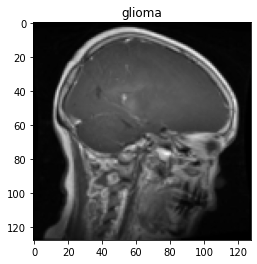

In [199]:
training_set = ImageFolder("./data/Training", transform=transform("elastic"))
train_loader = DataLoader(training_set, 64, shuffle=True, drop_last=True)

for img, label in train_loader:
    plt.title(training_set.classes[label[0]])
    plt.imshow(img[0].squeeze()[0,:,:], cmap='gray')
    break

In [239]:
training_set.classes

['glioma', 'meningioma', 'notumor', 'pituitary']

## Model

Our data generator is now ready to feed batches of data into a model. Let's design a model and pass it our training data.

In [32]:
import torch
import torch.nn as nn
from torchvision import models

In [33]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=4):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.drop = nn.Dropout(0.15)
        
        self.fc=nn.Linear(32*64*64, 4)
        
    def forward(self,img):
        output=self.conv1(img)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output = self.drop(output)
        output=output.view(-1,32*64*64)
        output=self.fc(output)
        return output


In [248]:
def train(model, train_loader, validation_loader, optimizier, loss_fun, transformType, epochs=40):
    training_accuracies = []
    training_losses = []
    validation_accuracies = []
    validation_losses = []
    
    # Early stopping
    the_last_loss = 100
    patience = 2
    trigger_times = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_accuracy=0.0
        train_loss=0.0
        
        for images, labels in train_loader:
            # Zero grads
            optimizer.zero_grad()
        
            # Predict
            outputs=model(images)
            
            # Compute loss and update gradients
            loss=loss_function(outputs,labels)
            loss.backward()
            optimizer.step()
            
            predicted = outputs.argmax(axis=1)
            train_accuracy+=int(torch.sum(predicted==labels.data))
            train_loss+= loss.cpu().data*images.size(0)
            
        train_accuracy=train_accuracy/len(training_set)
        train_loss=train_loss/len(training_set)
        training_accuracies.append(train_accuracy * 100)
        training_losses.append(train_loss.item())
        
        # Validation
        model.eval()
        validation_accuracy=0.0
        validation_loss = 0.0
        
        with torch.no_grad():
            for images, labels in validation_loader:
                # Predict
                outputs=model(images)
                
                loss=loss_function(outputs,labels)
                validation_loss+= loss.cpu().data*images.size(0)

                predicted = outputs.argmax(axis=1)
                validation_accuracy+=int(torch.sum(predicted==labels.data))
            
        validation_accuracy=validation_accuracy/len(validation_set)
        validation_loss=validation_loss/len(validation_set)
        validation_accuracies.append(validation_accuracy*100)
        validation_losses.append(validation_loss.item())

        if validation_loss.item() > the_last_loss:
            trigger_times += 1
            if trigger_times >= patience:
                print(f'EARLY STOPPING - Trigger times: {trigger_times}')
                torch.save(model.state_dict(), f'{transformType}-model.pt')
                return training_accuracies, validation_accuracies, training_losses, validation_losses
        else:
            trigger_times = 0

        the_last_loss = validation_loss.item()
        
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        print(f'Training loss: {str(train_loss.item())} Training acc: {str(train_accuracy*100)}')
        print(f'Validation loss: {str(validation_loss.item())} Validation acc: {str(validation_accuracy*100)}')
        print('-'*50)
    
    torch.save(model.state_dict(), f'{transformType}-model.pt')
    return training_accuracies, validation_accuracies, training_losses, validation_losses
    
def test(model, test_loader, transformType, metrics):
    y_pred=[]
    y_actual=[]
    model.load_state_dict(torch.load(f'{transformType}-model.pt'))
    with torch.no_grad():
        testing_accuracy = 0
        for images, labels in test_loader:
            # Predict
            outputs=model(images)
            
            # Accuracy
            predicted = outputs.argmax(axis=1)
            testing_accuracy+=int(torch.sum(predicted==labels.data))
            
            y_actual+=list(np.array(labels.detach().to('cpu')).flatten())
            y_pred+=list(np.array(predicted.detach().to('cpu')).flatten())
            
        print(f"Testing accuracy: {(testing_accuracy/len(testing_set))*100}\n")
        y_actual=np.array(y_actual).flatten()
        y_pred=np.array(y_pred).flatten()
        
        metrics[transformType]['testingAccuracy'] = (testing_accuracy/len(testing_set))*100
        metrics[transformType]['y_actual'] = y_actual
        metrics[transformType]['y_pred'] = y_pred
        
        return y_actual, y_pred

In [249]:
from torch.optim import Adam
metrics = {}
EPOCHS = 30

for transformType in ["brightness", "flip", "rotation", "scale", "elastic"]:
    model = ConvNet()
    optimizer=Adam(model.parameters(),lr=0.001)
    loss_function=nn.CrossEntropyLoss()
    training_set = ImageFolder("./data/Training", transform=transform(transformType))
    testing_set = ImageFolder("./data/Testing", transform=transform(transformType))
    testing_set, validation_set = random_split(testing_set, [1000, 311])
    
    train_loader = DataLoader(training_set, 64, shuffle=True, drop_last=True)
    test_loader = DataLoader(testing_set, 32, shuffle=True, drop_last=True)
    validation_loader = DataLoader(validation_set, 32, shuffle=True, drop_last=True)

    print(f"=================== Training model for {transformType} ===================")
    training_accuracies, validation_accuracies, training_losses, validation_losses = train(model, train_loader, validation_loader, optimizer, loss_function, transformType, epochs=EPOCHS)
    metrics[transformType] = {
        "trainingAccuracies": training_accuracies,
        "validationAccuracies": validation_accuracies,
        "trainingLosses": training_losses,
        "validationLosses": validation_losses
    }
    
    print("\nTESTING MODEL")
    y_actual, y_pred = test(model, test_loader, transformType, metrics)

=================== Training model for brightness ===================
[INFO]: Epoch 1 of 30
Training loss: 3.5397627353668213 Training acc: 69.92296918767506
Validation loss: 1.2339056730270386 Validation acc: 73.95498392282958
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training loss: 0.5602024793624878 Training acc: 88.28781512605042
Validation loss: 0.5432039499282837 Validation acc: 83.60128617363344
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training loss: 0.21972611546516418 Training acc: 93.59243697478992
Validation loss: 0.3956259787082672 Validation acc: 84.88745980707395
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training loss: 0.15039865672588348 Training acc: 95.4656862745098
Validation loss: 0.8623479604721069 Validation acc: 80.06430868167203
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training loss: 0.14839516580104828 Training acc: 95.37815126050421
Vali

[INFO]: Epoch 5 of 30
Training loss: 0.5817893147468567 Training acc: 88.48039215686273
Validation loss: 1.3321086168289185 Validation acc: 75.56270096463022
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training loss: 0.506581723690033 Training acc: 89.33823529411765
Validation loss: 0.44010600447654724 Validation acc: 82.31511254019293
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training loss: 0.4285087287425995 Training acc: 90.33613445378151
Validation loss: 0.6726901531219482 Validation acc: 79.42122186495176
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training loss: 0.33842602372169495 Training acc: 91.85924369747899
Validation loss: 0.36227765679359436 Validation acc: 84.88745980707395
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training loss: 0.23574306070804596 Training acc: 93.78501400560224
Validation loss: 0.39790427684783936 Validation acc: 81.02893890675242
--

## Plot results

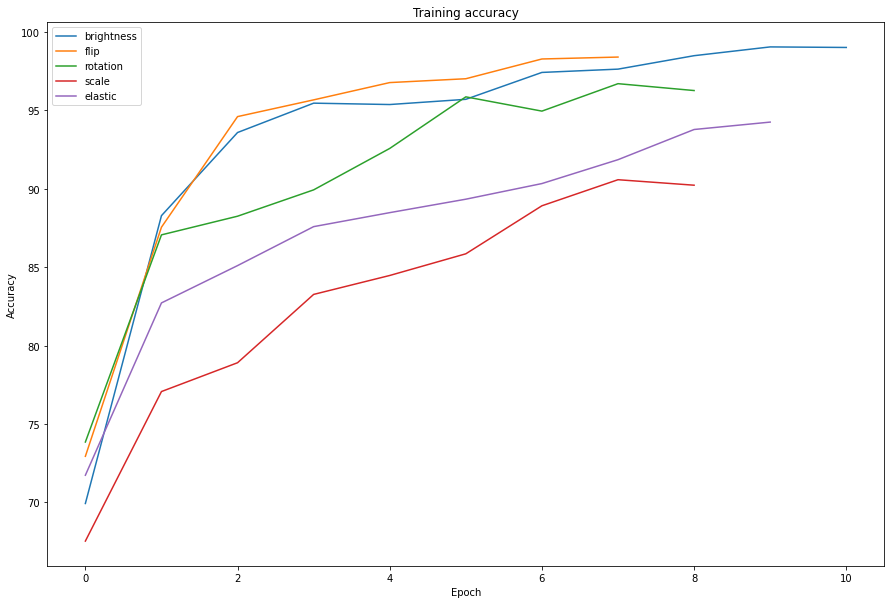

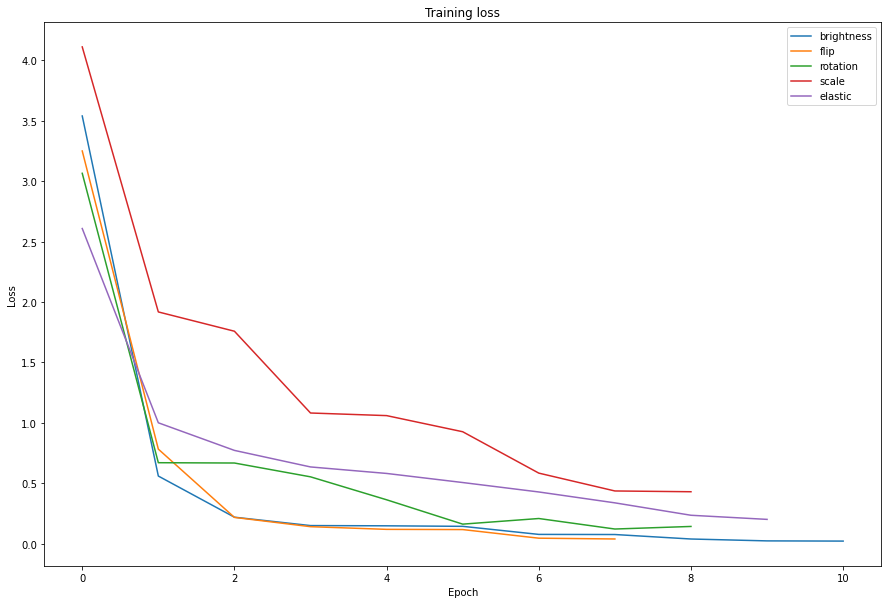

In [250]:
fig = plt.figure(figsize = (15, 10))

for transformType in ["brightness", "flip", "rotation", "scale", "elastic"]:    
    plt.title("Training accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    x = np.arange(len(metrics[transformType]['trainingAccuracies']))
    plt.plot(x, metrics[transformType]['trainingAccuracies'], label=f"{transformType}")
    plt.legend()
    
fig = plt.figure(figsize = (15, 10))
for transformType in ["brightness", "flip", "rotation", "scale", "elastic"]:    
    plt.title("Training loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    x = np.arange(len(metrics[transformType]['trainingLosses']))
    plt.plot(x, metrics[transformType]['trainingLosses'], label=f"{transformType}")
    plt.legend()

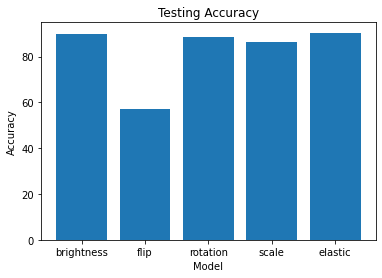

In [279]:
def plt_bar_chart(X, y, xlabel, ylabel, title):
    '''
    Plot bar chart for model and metric
    '''
    plt.bar(X, y)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()
    
testing_acc = []
for transformType in ["brightness", "flip", "rotation", "scale", "elastic"]:
    testing_acc.append(metrics[transformType]["testingAccuracy"])
    
plt_bar_chart(["brightness", "flip", "rotation", "scale", "elastic"], testing_acc, "Model", "Accuracy", "Testing Accuracy")

In [272]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

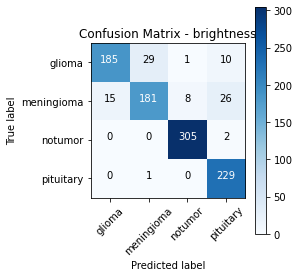

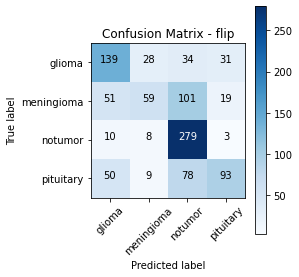

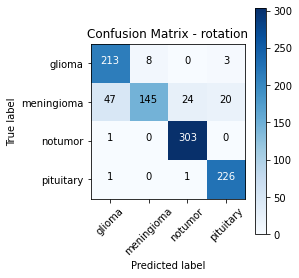

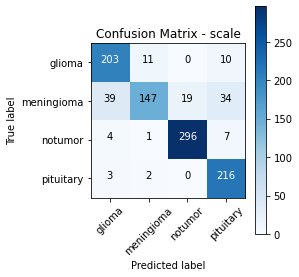

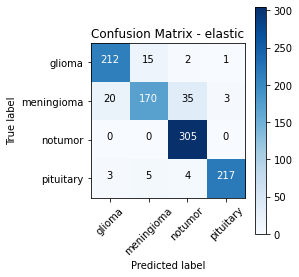

In [271]:
for transformType in ["brightness", "flip", "rotation", "scale", "elastic"]:
    fig = plt.figure(figsize = (4,4))
    plot_confusion_matrix(confusion_matrix(metrics[transformType]['y_actual'], metrics[transformType]['y_pred']), training_set.classes, title=f"Confusion Matrix - {transformType}")